In [18]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [19]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [20]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [21]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0 
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [22]:
data_index = 0

def generate_batch(batch_size, skip_window):

    global data_index

    span = 2 * skip_window + 1 

    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    buffer = collections.deque(maxlen=span)

    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    for i in range(batch_size):
        target = skip_window 
        target_to_avoid = [ skip_window ] 

        col_idx = 0
        for j in range(span):
            if j==span//2:
                continue

            batch[i,col_idx] = buffer[j] 
            col_idx += 1
        labels[i, 0] = buffer[target]

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    assert batch.shape[0]==batch_size and batch.shape[1]== span-1
    return batch, labels



for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with num_skips = 2 and skip_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [23]:
num_steps = 100001

if __name__ == '__main__':
    batch_size = 128
    embedding_size = 128 
    skip_window = 1 
    num_skips = 2 

    valid_size = 16
    valid_window = 100 

    window = 16
    valid_examples = np.array(random.sample(range(window), valid_size))
    #it will generate first 16 words from count variable in random sequence
    num_sampled = 64 

    graph = tf.Graph()

    with graph.as_default(), tf.device('/cpu:0'):

        train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*skip_window])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
        softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

        context_embeddings = []
        for i in range(2*skip_window):
            context_embeddings.append(tf.nn.embedding_lookup(embeddings, train_dataset[:,i]))
            
        avg_embed =  tf.reduce_mean(tf.stack(axis=0,values=context_embeddings),0,keep_dims=False)
        #it takes average of all embeddings of neighbouring inputs of particular sentence which is different from skip gram

        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=avg_embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

        optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0
        for step in range(num_steps):
            batch_data, batch_labels = generate_batch(batch_size, skip_window)
            feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l
            if step % 2000 == 0:
                if step > 0:
                    average_loss = average_loss / 2000
                   
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
           
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8 
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
        final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.872447
Nearest to to: amused, drava, elaborates, olfactory, inverse, voss, muddy, montaigne,
Nearest to two: reappeared, intruders, provisions, exposes, cdna, laes, tipped, aesthetics,
Nearest to eight: mockery, iras, allende, subpixels, resisting, terrier, transcriptions, dumb,
Nearest to the: hildebrand, commentators, overview, anodes, procol, autobahn, infested, fretting,
Nearest to of: assays, doherty, mummification, volts, assimilate, zhang, damon, encircle,
Nearest to nine: rial, assassins, leinster, yelled, ausw, acutely, juli, wounded,
Nearest to for: circumstance, plastic, groupoids, demolished, alberto, safeguard, palliative, heinz,
Nearest to zero: zones, satchmo, ima, thicknesses, asthma, beetles, balearic, misled,
Nearest to a: pigpen, finders, craters, copyrighted, dosage, hostels, nauvoo, unseen,
Nearest to UNK: aor, elaborating, leaked, genius, periodicals, lucille, ynys, unconquered,
Nearest to as: climactic, simile, naiste, canner

Average loss at step 52000: 2.885486
Average loss at step 54000: 2.859768
Average loss at step 56000: 2.856158
Average loss at step 58000: 2.758638
Average loss at step 60000: 2.829426
Nearest to to: towards, might, will, cannot, must, would, nec, tentatively,
Nearest to two: three, four, six, five, seven, one, eight, zero,
Nearest to eight: nine, seven, six, four, five, three, zero, two,
Nearest to the: its, their, your, this, his, our, a, any,
Nearest to of: ness, outboard, including, freeza, exact, dyadic, although, squaw,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to for: including, without, smithers, msx, groupoids, during, ged, despite,
Nearest to zero: five, seven, six, eight, four, nine, three, two,
Nearest to a: another, the, finders, craters, lighted, unipolar, affixes, relatively,
Nearest to UNK: la, der, von, kilobit, l, le, friedrich, www,
Nearest to as: welland, insensible, creditor, because, confessing, valle, surprisingly, cannery,
Nearest

In [24]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

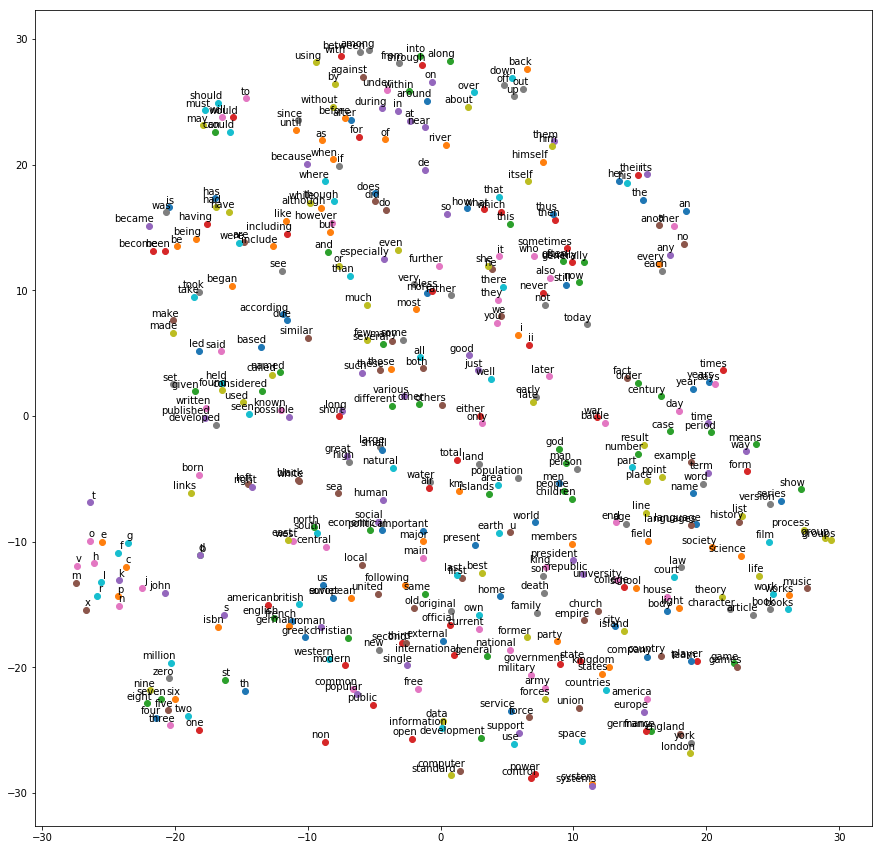

In [25]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15)) 
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)